## Data Science Challenge

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.txt', header=None, names=['t', 'w'])

In [4]:
df.head()

,t,w
0,1312182000,1322
1,1312182001,1322
2,1312182002,1328
3,1312182003,1328
4,1312182004,1328


In [5]:
min_time = min(df['t'])
df['t'] = df['t'] - min_time

In [6]:
dfs = df.iloc[:10000]

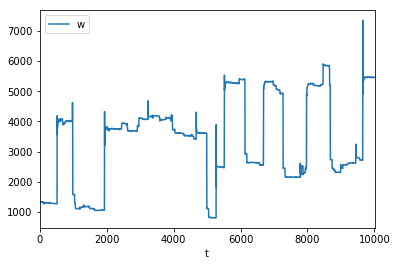

In [7]:
dfs.set_index('t').plot()

## Appliances

* _10min = 600
* _30min = 3 * _10min
* _1hr = 3600
* _3hrs = 3 * _1hr


* AC1: 2,500 W / _10min
* AC2: 4,000 W / _30min
* Pool Pamp: 1,500 W  / _3hrs
* Fridge: 200 W 

Extract each device's energy consumption time-series.

### Possible Approaches:

* Steady state;
steps/transitions 

In [8]:
DELTA = 50

Smooth out data. Any change less than DELTA is ignored.

In [9]:
df_shifted = df.shift(1)

In [10]:
df['dw'] = df['w'] - df_shifted['w']

In [11]:
df.head(10)

,t,w,dw
0,0,1322,NaN
1,1,1322,0.0
2,2,1328,6.0
3,3,1328,0.0
4,4,1328,0.0
5,5,1328,0.0
6,6,1328,0.0
7,7,1320,-8.0
8,8,1320,0.0
9,9,1320,0.0


In [12]:
df.loc[abs(df['dw']) < DELTA, 'dw'] = 0

In [13]:
df[df['dw'] < 0].head()

,t,w,dw
523,524,3560,-630.0
590,591,4000,-78.0
682,683,3946,-130.0
687,688,3886,-60.0
979,981,4094,-530.0


In [14]:
changes_df = df[abs(df['dw']) > 0].copy()

In [15]:
changes_df['dt'] = changes_df['t'] - changes_df.shift(1)['t']
changes_df['prev_w'] = changes_df['w'] - changes_df['dw']

### Combinatorial Optimization

Our set of devices is small, so we can apply a CO algorithm. We don't use data about durations yet.

In [16]:
devices = {"f": 200, "pp": 1500, "ac1": 2500, "ac2": 4000}
combos = {}
combos_by_energy = {}

In [17]:
def build_combos(s: set):
    if not s:
        return [()]
    n = s.pop()
    subsets = build_combos(s)
    extra = []
    for sb in subsets:
        nset = (n,) + sb
        extra.append(nset)
    subsets.extend(extra)
    return subsets

In [18]:
def power(devices, subset):
    result = 0
    for d in subset:
        result += devices[d]
    return result

tuple_sets = build_combos(set(devices.keys()))
set_sets = [set(r) for r in tuple_sets]

for t, s in zip(tuple_sets, set_sets):
    combos[t] = power(devices, t)
    combos_by_energy[power(devices, t)] = s

In [19]:
combos

{(): 0,
 ('ac1',): 2500,
 ('ac1', 'ac2'): 6500,
 ('ac2',): 4000,
 ('f',): 200,
 ('f', 'ac1'): 2700,
 ('f', 'ac1', 'ac2'): 6700,
 ('f', 'ac2'): 4200,
 ('f', 'pp'): 1700,
 ('f', 'pp', 'ac1'): 4200,
 ('f', 'pp', 'ac1', 'ac2'): 8200,
 ('f', 'pp', 'ac2'): 5700,
 ('pp',): 1500,
 ('pp', 'ac1'): 4000,
 ('pp', 'ac1', 'ac2'): 8000,
 ('pp', 'ac2'): 5500}

In [20]:
combos_by_energy

{0: set(),
 200: {'f'},
 1500: {'pp'},
 1700: {'f', 'pp'},
 2500: {'ac1'},
 2700: {'ac1', 'f'},
 4000: {'ac1', 'pp'},
 4200: {'ac1', 'f', 'pp'},
 5500: {'ac2', 'pp'},
 5700: {'ac2', 'f', 'pp'},
 6500: {'ac1', 'ac2'},
 6700: {'ac1', 'ac2', 'f'},
 8000: {'ac1', 'ac2', 'pp'},
 8200: {'ac1', 'ac2', 'f', 'pp'}}

Iterate over each row, find the closest energy, and set those devices to turned on.

In [21]:
series_base = {'ac1': 0, 'ac2': 0, 'f': 0, 'pp': 0}

In [22]:
def device_on(w, device_name):
    closest_e = -1
    diff = 1 * float("inf")
    for e in combos_by_energy:
        cur_diff = abs(w - e)
        if cur_diff < diff:
            diff = cur_diff
            closest_e = e
    devices_on = combos_by_energy[closest_e]
    on = device_name in devices_on
    return devices[device_name] if on else 0

First build a naive time series where each device consumesthe exact amount of power as in its specification. Then, we will split the actual usage among active devices.

In [23]:
df['ac1'] = df['w'].map(lambda w: device_on(w, 'ac1'))
df['ac2'] = df['w'].map(lambda w: device_on(w, 'ac2'))
df['f'] = df['w'].map(lambda w: device_on(w, 'f'))
df['pp'] = df['w'].map(lambda w: device_on(w, 'pp'))

Now split the actual power used among active devices:

1. Calculate sum
2. Ratio of each device: spec_w / sum
3. Calculate new actual valus as w * ratio

In [24]:
df['total_spec_w'] = df[['ac1', 'ac2', 'f', 'pp']].sum(axis=1)
for d in devices.keys():
    df[d + '_ratio'] = df[d] / df['total_spec_w']

for d in devices.keys():
    df[d + '_actual'] = df['w'] * df[d + '_ratio']

In [25]:
df['t'] = df['t'] + min_time

In [26]:
df.head(10)

,t,w,dw,ac1,ac2,f,pp,total_spec_w,f_ratio,pp_ratio,ac2_ratio,ac1_ratio,f_actual,pp_actual,ac2_actual,ac1_actual
0,1312182000,1322,NaN,0,0,0,1500,1500,0.0,1.0,0.0,0.0,0.0,1322.0,0.0,0.0
1,1312182001,1322,0.0,0,0,0,1500,1500,0.0,1.0,0.0,0.0,0.0,1322.0,0.0,0.0
2,1312182002,1328,0.0,0,0,0,1500,1500,0.0,1.0,0.0,0.0,0.0,1328.0,0.0,0.0
3,1312182003,1328,0.0,0,0,0,1500,1500,0.0,1.0,0.0,0.0,0.0,1328.0,0.0,0.0
4,1312182004,1328,0.0,0,0,0,1500,1500,0.0,1.0,0.0,0.0,0.0,1328.0,0.0,0.0
5,1312182005,1328,0.0,0,0,0,1500,1500,0.0,1.0,0.0,0.0,0.0,1328.0,0.0,0.0
6,1312182006,1328,0.0,0,0,0,1500,1500,0.0,1.0,0.0,0.0,0.0,1328.0,0.0,0.0
7,1312182007,1320,0.0,0,0,0,1500,1500,0.0,1.0,0.0,0.0,0.0,1320.0,0.0,0.0
8,1312182008,1320,0.0,0,0,0,1500,1500,0.0,1.0,0.0,0.0,0.0,1320.0,0.0,0.0
9,1312182009,1320,0.0,0,0,0,1500,1500,0.0,1.0,0.0,0.0,0.0,1320.0,0.0,0.0


### Plot individual devices

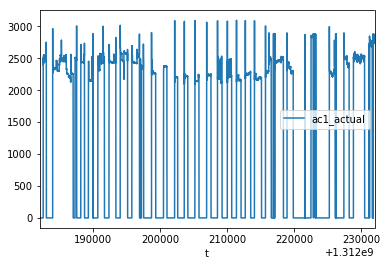

In [27]:
def plot_device(df, name):
    df.iloc[:50000][['t', name]].set_index('t').plot()
    
plot_device(df, 'ac1_actual')

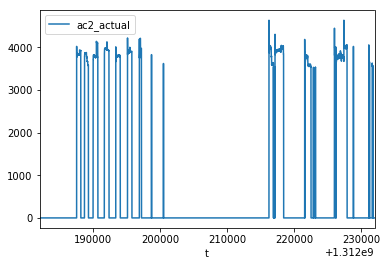

In [28]:
plot_device(df, 'ac2_actual')

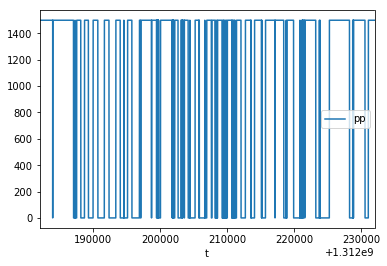

In [29]:
plot_device(df, 'pp')

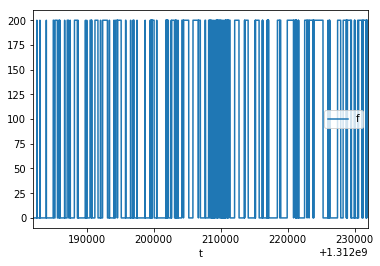

In [30]:
plot_device(df, 'f')